### Análisis de sentimientos de las reseñas.

Para comenzar, se importan las librerías requeridas

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re
import nltk
from unidecode import unidecode
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
import spacy
from wordcloud import WordCloud
from tqdm import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from langdetect import detect

[nltk_data] Downloading package wordnet to C:\Users\PcOne
[nltk_data]     Mexico\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\PcOne
[nltk_data]     Mexico\AppData\Roaming\nltk_data...


Se agrega el archivo que contiene las reseñas a un dataframe

In [5]:
df_reseñas=pd.read_parquet('reseñas.parquet')
df_reseñas.head()

user_id                                             review  \
0  76561197970982479  Simple yet with great replayability. In my opi...   
1  76561197970982479               It's unique and worth a playthrough.   
2  76561197970982479  Great atmosphere. The gunplay can be a bit chu...   
3            js41637  I know what you think when you see this title ...   
4            js41637  For a simple (it's actually not all that simpl...   

   item_id      0     1     Año  año_modaitem  
0     1250  False  True  2011.0        2014.0  
1    22200  False  True  2011.0        2011.0  
2    43110  False  True  2011.0        2014.0  
3   251610  False  True  2014.0        2014.0  
4   227300  False  True  2013.0        2014.0

Se descargan las palabras vacías de los tres idiomas principales que se identificaron durante el ETL del archivo: español, inglés y portugués. Es importante recordar que las palabras vacías son aquellas palabras que carecen de un significado relevante por sí solas en el contexto de la búsqueda y el procesamiento de lenguaje natural.

In [7]:
import nltk

# Descargar el recurso de stopwords
nltk.download('stopwords')

# Importar stopwords para varios idiomas
from nltk.corpus import stopwords

stopwords_en = stopwords.words('english')
stopwords_sp = stopwords.words('spanish')
stopwords_pt = stopwords.words('portuguese')

# Mostrar algunas stopwords en inglés como ejemplo
print(stopwords_en[:10])


[nltk_data] Downloading package stopwords to C:\Users\PcOne
[nltk_data]     Mexico\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [10]:
import spacy

nlp_english = spacy.load('en_core_web_sm')      # Cargamos nlp en inglés
nlp_spanish = spacy.load('es_core_news_sm')     # Cargamos nlp en español
nlp_portuguese = spacy.load('pt_core_news_sm')  # Cargamos nlp en portugués


In [11]:
stopwords_en = nltk.corpus.stopwords.words('english')
stopwords_sp = nltk.corpus.stopwords.words('spanish')
stopwords_pt = nltk.corpus.stopwords.words('portuguese')
stopwords = stopwords_en + stopwords_pt + stopwords_sp

# definimos una función para limpiar los textos de reviews

def clean_text(rev):
    if pd.isna(rev) or rev is None:
        return rev
    else:
        # limpieza
        rev = str(rev)
        rev = rev.lower()
        rev= rev.replace('\n', '')
        rev = unidecode(rev)
        rev = re.sub(r'https?://\S+|www\.\S+', '', rev)

        # tokenización
        rev = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(rev)

        # quitar stopwords
        rev = [word.strip() for word in rev if word not in stopwords]
        return rev

nlp_english = spacy.load('en_core_web_sm')          # cargamos nlp en inglés, español y portugués
nlp_spanish = spacy.load('es_core_news_sm')
nlp_portuguese = spacy.load('pt_core_news_sm')

# definimos una función para cambiar la función posicional de las palabras a una expresión de una sola letra
def get_wordnet_pos(pos):
    if pos == 'VERB':
        return 'v'
    elif pos == 'ADJ':
        return 'a'
    elif pos == 'ADV':
        return 'r'
    elif pos == 'NOUN':
        return 'n'
    else:
        return 'n'

# definimos una función para lemmatizar el texto de cada review
def lemmatize_text(rev):
    if rev is None:
        return rev

    lemmatizer = WordNetLemmatizer()

    # Obtener posiciones gramaticales en un conjunto
    pos_set = {'VERB', 'ADJ', 'ADV', 'NOUN'}

    # seleccionamos el nlp según el idioma que se detecta:
    try:
        lang = detect(' '.join(rev))
    except Exception as e:
        lang = 'en'  # Si hay un error, utiliza inglés como predeterminado  
    
    if lang == 'en':
        nlp = nlp_english
    elif lang == 'es':
        nlp = nlp_spanish
    elif lang == 'pt':
        nlp = nlp_portuguese
    else:
        # Si no se detecta un idioma específico, utiliza inglés como predeterminado
        nlp = nlp_english

    # Lematizar en lotes usando spaCy
    doc = nlp(' '.join(rev))

    lemmatized_words = [lemmatizer.lemmatize(token.text, get_wordnet_pos(token.pos_)) for token in doc if token.pos_ in pos_set]

    return lemmatized_words

In [12]:
df_reseñas['review_tokenized'] = df_reseñas['review'].apply(clean_text)
df_reseñas.head()

user_id                                             review  \
0  76561197970982479  Simple yet with great replayability. In my opi...   
1  76561197970982479               It's unique and worth a playthrough.   
2  76561197970982479  Great atmosphere. The gunplay can be a bit chu...   
3            js41637  I know what you think when you see this title ...   
4            js41637  For a simple (it's actually not all that simpl...   

   item_id      0     1     Año  año_modaitem  \
0     1250  False  True  2011.0        2014.0   
1    22200  False  True  2011.0        2011.0   
2    43110  False  True  2011.0        2014.0   
3   251610  False  True  2014.0        2014.0   
4   227300  False  True  2013.0        2014.0   

                                    review_tokenized  
0  [simple, yet, great, replayability, opinion, z...  
1                       [unique, worth, playthrough]  
2  [great, atmosphere, gunplay, bit, chunky, time...  
3  [know, think, see, title, barbie, dreamhouse, ...  
4  [simple, actually, simple, truck, driving, sim...

Luego, se genera una nube de palabras

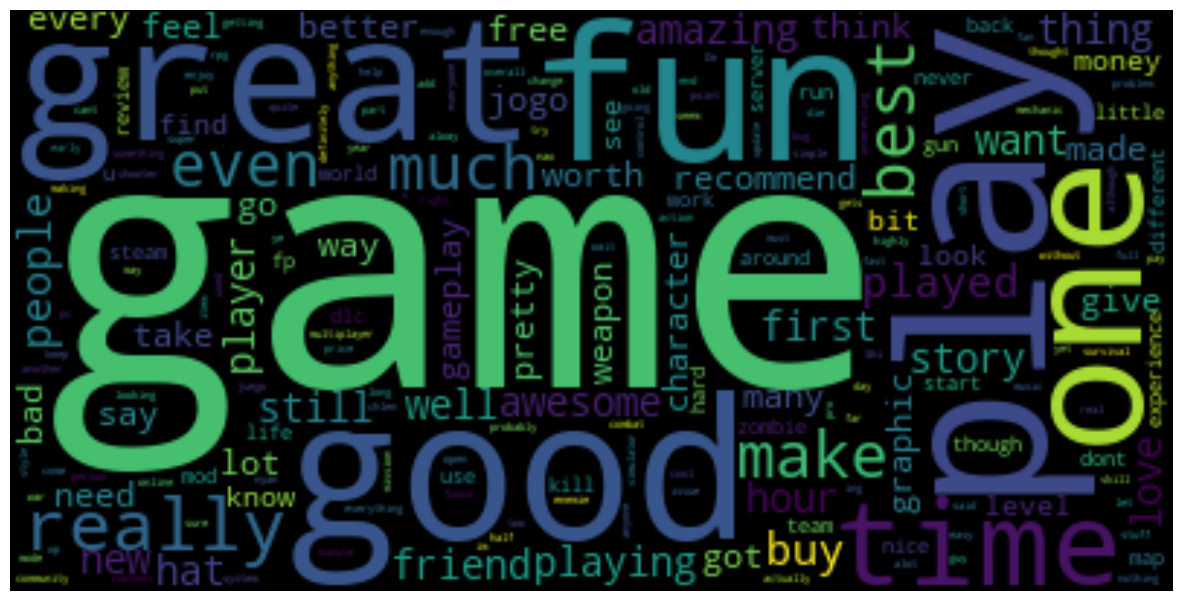

In [13]:
text = " ".join(i for i in df_reseñas['review_tokenized'].apply(lambda x: ' '.join(x) if x is not None else None) if i is not None)
wordcloud = WordCloud(collocations=False).generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Se añade una libreria que permite incorporar barras de progreso, ya que se harán procesos tardados.

In [14]:
tqdm.pandas()

Se aplica la función a la columna

In [15]:
df_reseñas['review_lemmatized'] = df_reseñas['review_tokenized'].progress_apply(lemmatize_text)

100%|██████████| 58431/58431 [23:35<00:00, 41.27it/s] 


In [16]:
df_reseñas.head()

user_id                                             review  \
0  76561197970982479  Simple yet with great replayability. In my opi...   
1  76561197970982479               It's unique and worth a playthrough.   
2  76561197970982479  Great atmosphere. The gunplay can be a bit chu...   
3            js41637  I know what you think when you see this title ...   
4            js41637  For a simple (it's actually not all that simpl...   

   item_id      0     1     Año  año_modaitem  \
0     1250  False  True  2011.0        2014.0   
1    22200  False  True  2011.0        2011.0   
2    43110  False  True  2011.0        2014.0   
3   251610  False  True  2014.0        2014.0   
4   227300  False  True  2013.0        2014.0   

                                    review_tokenized  \
0  [simple, yet, great, replayability, opinion, z...   
1                       [unique, worth, playthrough]   
2  [great, atmosphere, gunplay, bit, chunky, time...   
3  [know, think, see, title, barbie, dreamhouse, ...   
4  [simple, actually, simple, truck, driving, sim...   

                                   review_lemmatized  
0  [simple, great, replayability, opinion, team, ...  
1                       [unique, worth, playthrough]  
2  [great, atmosphere, gunplay, bit, chunky, time...  
3  [know, think, see, title, barbie, dreamhouse, ...  
4  [simple, actually, simple, truck, drive, simul...

Se genera una nube de palabras lematizadas.

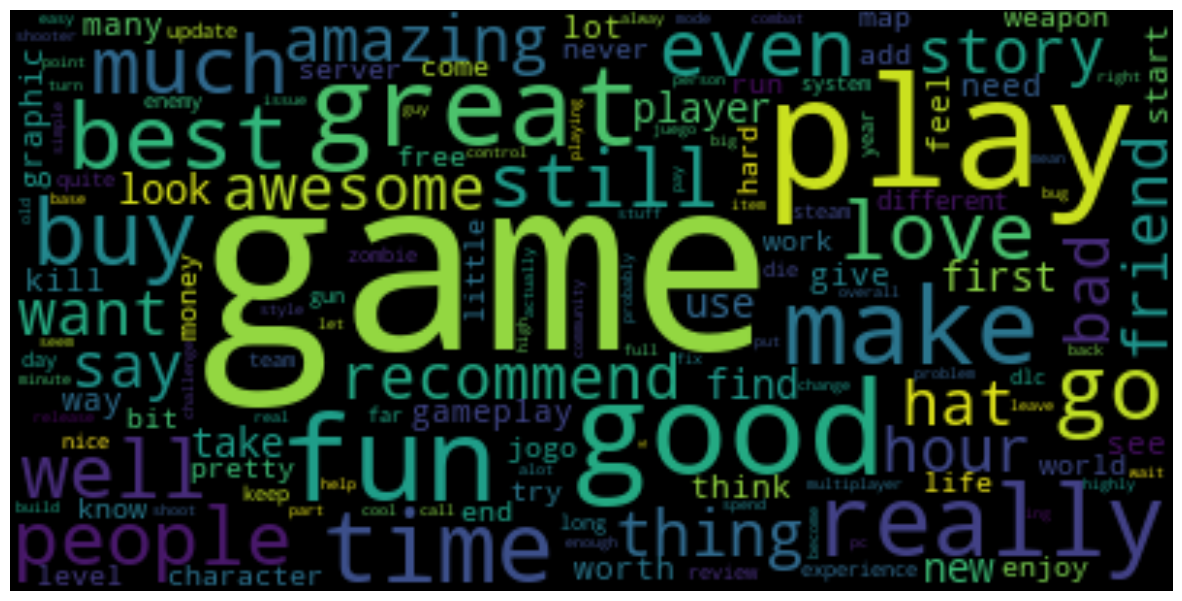

In [17]:
text = " ".join(i for i in df_reseñas['review_lemmatized'].apply(lambda x: ' '.join(x) if x is not None else None) if i is not None)
wordcloud = WordCloud(collocations=False).generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [18]:
df_reseñas['rev_complete'] = df_reseñas['review_lemmatized'].progress_apply(lambda x: ' '.join(x) if x is not None else None)

100%|██████████| 58431/58431 [00:00<00:00, 357507.37it/s]


In [21]:
df_reseñas.drop(columns='0', axis=1, inplace=True)

In [22]:
df_reseñas=df_reseñas.rename(columns={'1':'recommend'})

In [23]:
df_reseñas.head()

user_id                                             review  \
0  76561197970982479  Simple yet with great replayability. In my opi...   
1  76561197970982479               It's unique and worth a playthrough.   
2  76561197970982479  Great atmosphere. The gunplay can be a bit chu...   
3            js41637  I know what you think when you see this title ...   
4            js41637  For a simple (it's actually not all that simpl...   

   item_id  recommend     Año  año_modaitem  \
0     1250       True  2011.0        2014.0   
1    22200       True  2011.0        2011.0   
2    43110       True  2011.0        2014.0   
3   251610       True  2014.0        2014.0   
4   227300       True  2013.0        2014.0   

                                    review_tokenized  \
0  [simple, yet, great, replayability, opinion, z...   
1                       [unique, worth, playthrough]   
2  [great, atmosphere, gunplay, bit, chunky, time...   
3  [know, think, see, title, barbie, dreamhouse, ...   
4  [simple, actually, simple, truck, driving, sim...   

                                   review_lemmatized  \
0  [simple, great, replayability, opinion, team, ...   
1                       [unique, worth, playthrough]   
2  [great, atmosphere, gunplay, bit, chunky, time...   
3  [know, think, see, title, barbie, dreamhouse, ...   
4  [simple, actually, simple, truck, drive, simul...   

                                        rev_complete  
0  simple great replayability opinion team work w...  
1                           unique worth playthrough  
2  great atmosphere gunplay bit chunky time end d...  
3  know think see title barbie dreamhouse party i...  
4  simple actually simple truck drive simulator q...

Se conserva en el dataframe las columnas que serán empleadas posteriormente.

In [24]:
df_reseñas_final = df_reseñas[['user_id', 'item_id', 'rev_complete', 'recommend', 'Año']]
df_reseñas_final.head()

user_id  item_id  \
0  76561197970982479     1250   
1  76561197970982479    22200   
2  76561197970982479    43110   
3            js41637   251610   
4            js41637   227300   

                                        rev_complete  recommend     Año  
0  simple great replayability opinion team work w...       True  2011.0  
1                           unique worth playthrough       True  2011.0  
2  great atmosphere gunplay bit chunky time end d...       True  2011.0  
3  know think see title barbie dreamhouse party i...       True  2014.0  
4  simple actually simple truck drive simulator q...       True  2013.0

Se agregan la columna feelings_analysis. Inicialmente, se empleará SentimentIntensityAnalizer de nltk

In [26]:
analyzer = SentimentIntensityAnalyzer()
df_reseñas_final['sentiment_analysis'] = df_reseñas_final['rev_complete'].progress_apply(lambda x: analyzer.polarity_scores(x)['compound'] if x is not None else 0)

  0%|          | 0/58431 [00:00<?, ?it/s]

100%|██████████| 58431/58431 [00:20<00:00, 2802.74it/s]


Se realiza la escala sea '1' si es malo, '2' si es neutral y '3' si es positivo, se aplica el cambio a la columna

In [33]:
df_reseñas_final['sentiment_analysis'] = df_reseñas_final['sentiment_analysis'] + 1

In [34]:
df_reseñas_final.head()

user_id  item_id  \
0  76561197970982479     1250   
1  76561197970982479    22200   
2  76561197970982479    43110   
3            js41637   251610   
4            js41637   227300   

                                        rev_complete  recommend     Año  \
0  simple great replayability opinion team work w...       True  2011.0   
1                           unique worth playthrough       True  2011.0   
2  great atmosphere gunplay bit chunky time end d...       True  2011.0   
3  know think see title barbie dreamhouse party i...       True  2014.0   
4  simple actually simple truck drive simulator q...       True  2013.0   

   sentiment_analysis  
0              1.8020  
1              1.2263  
2              1.8910  
3              1.8555  
4              1.9514

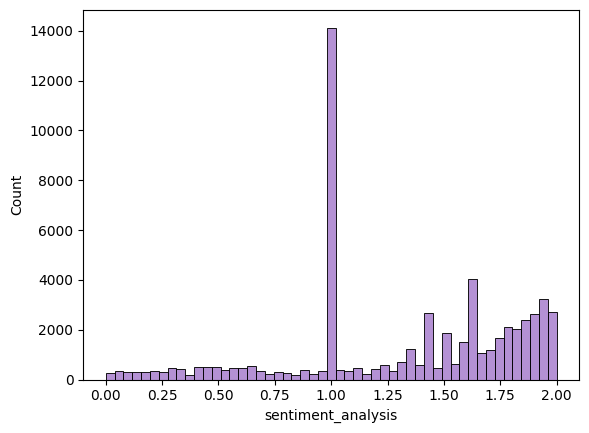

In [35]:
sns.histplot(df_reseñas_final['sentiment_analysis'],color='#9b6dc6');

La mayor parte de los comentarios tienen sentimientos neutros, además existen más comentarios positivos que negativos. Se visualizan cuantos comentarios vacíos se imputaron en neutro

In [36]:
df_reseñas.replace(['',' ', ['']], np.nan).isna().sum()

user_id                 0
review                 38
item_id                 0
recommend               0
Año                     0
año_modaitem         3606
review_tokenized       38
review_lemmatized      38
rev_complete         3045
dtype: int64

In [31]:
df_reseñas[df_reseñas_final['rev_complete'].isin(['',' ', ['']])]['review'].apply(clean_text).apply(lemmatize_text)

68       []
83       []
97       []
99       []
105      []
         ..
58366    []
58374    []
58379    []
58399    []
58429    []
Name: review, Length: 3007, dtype: object

In [37]:
df_reseñas[df_reseñas_final['rev_complete'].isin(['',' ', ['']])]['review'].apply(clean_text).apply(lemmatize_text)

68       []
83       []
97       []
99       []
105      []
         ..
58366    []
58374    []
58379    []
58399    []
58429    []
Name: review, Length: 3007, dtype: object

Reemplazamos 2964 datos que fueron imputados como neutros. Al parecer puede ser un mejor sistema asignar 2 en la columna sentiment analysis cuando recommend es 1, y 1 cuando recommend es 0.

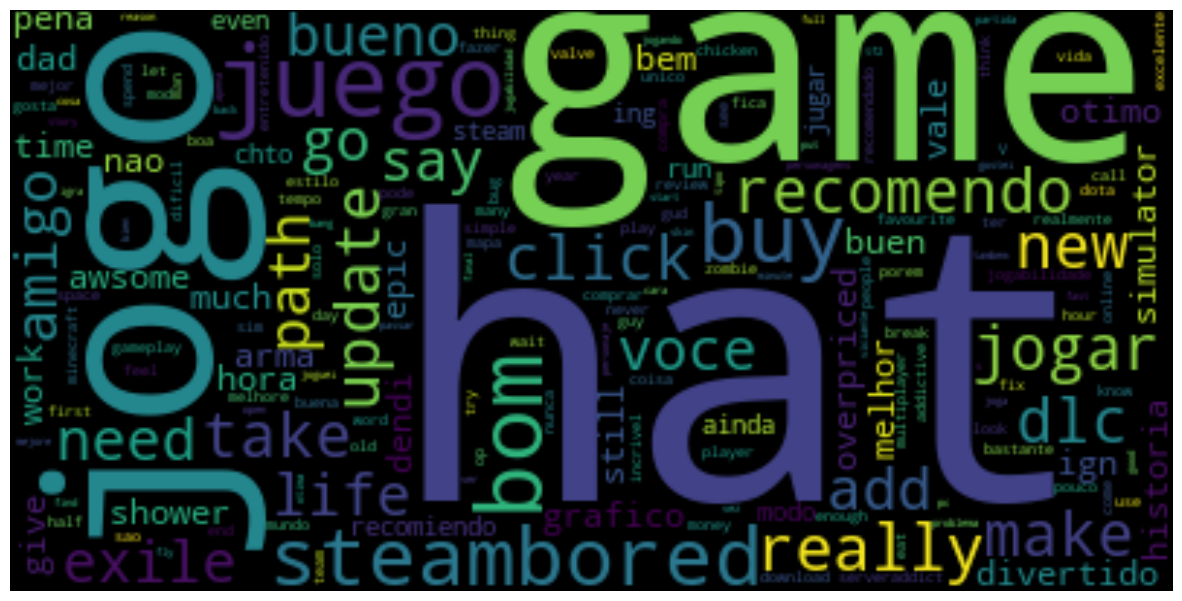

In [38]:
df_neutros = df_reseñas_final[df_reseñas_final['sentiment_analysis'] == 1]
text = " ".join(i for i in df_neutros['rev_complete'] if i is not None)
wordcloud = WordCloud(collocations=False).generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

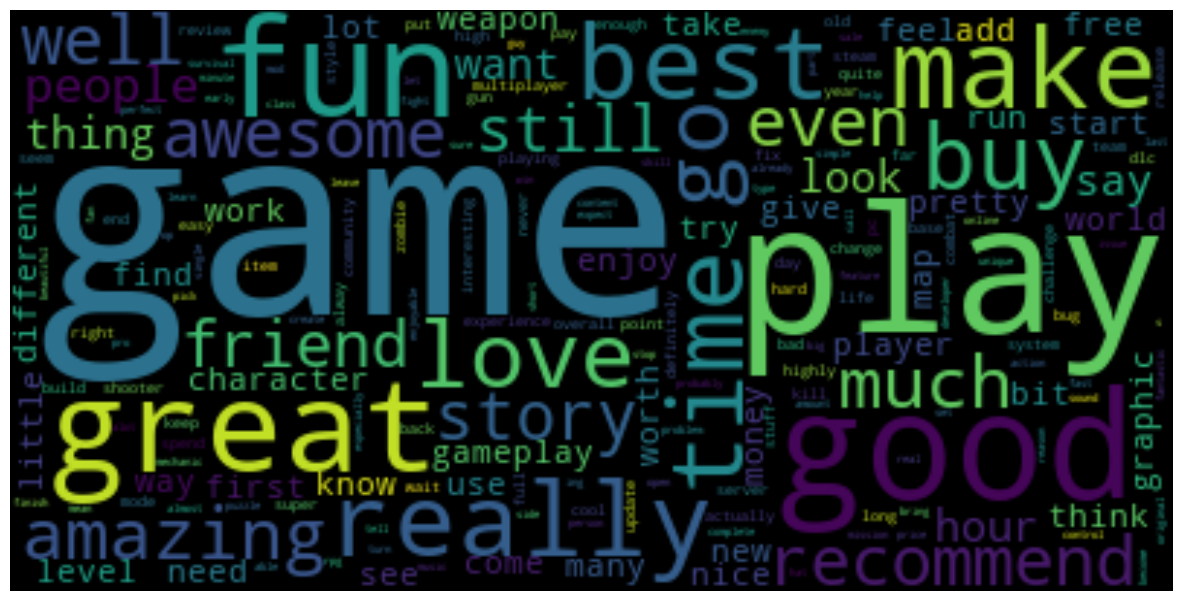

In [39]:
df_positivos = df_reseñas_final[df_reseñas_final['sentiment_analysis'] > 1]
text = " ".join(i for i in df_positivos['rev_complete'] if i is not None)
wordcloud = WordCloud(collocations=False).generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

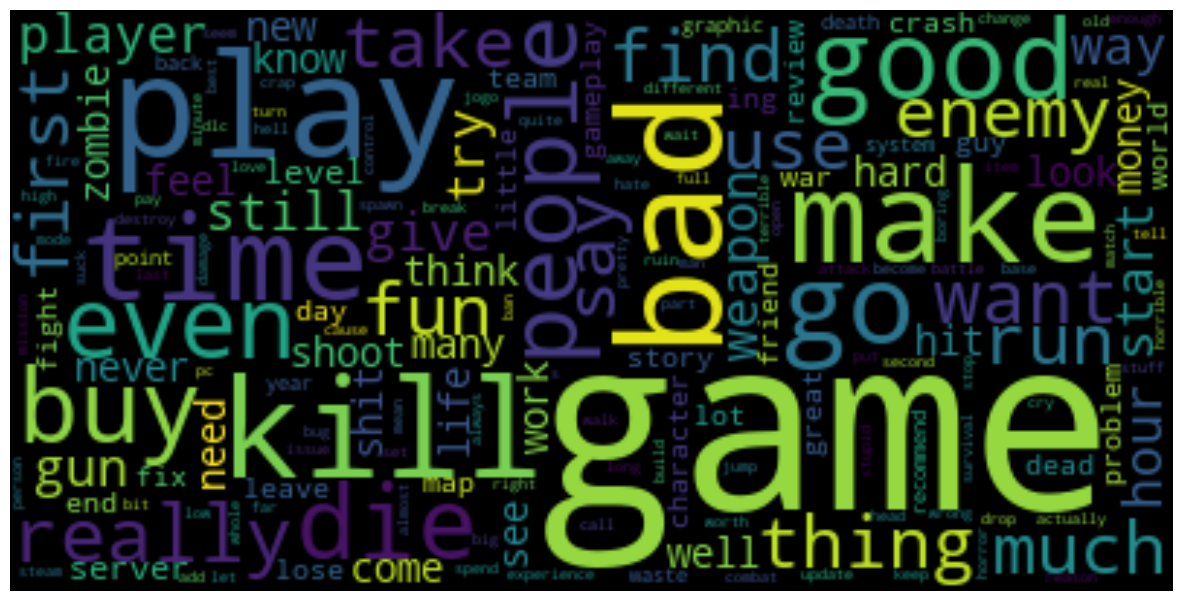

In [40]:
df_negativos = df_reseñas_final[df_reseñas_final['sentiment_analysis'] < 1]
text = " ".join(i for i in df_negativos['rev_complete'] if i is not None)
wordcloud = WordCloud(collocations=False).generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [41]:
df_reseñas_final.head()

user_id  item_id  \
0  76561197970982479     1250   
1  76561197970982479    22200   
2  76561197970982479    43110   
3            js41637   251610   
4            js41637   227300   

                                        rev_complete  recommend     Año  \
0  simple great replayability opinion team work w...       True  2011.0   
1                           unique worth playthrough       True  2011.0   
2  great atmosphere gunplay bit chunky time end d...       True  2011.0   
3  know think see title barbie dreamhouse party i...       True  2014.0   
4  simple actually simple truck drive simulator q...       True  2013.0   

   sentiment_analysis  
0              1.8020  
1              1.2263  
2              1.8910  
3              1.8555  
4              1.9514

In [42]:
df_to_parquet = df_reseñas_final[['user_id', 'item_id', 'sentiment_analysis', 'Año']]
df_to_parquet['sentiment_analysis'] = np.where(df_to_parquet['sentiment_analysis'] < 1 , 0, np.where(df_to_parquet['sentiment_analysis'] > 1, 2, 1 ))
df_to_parquet.head()

user_id  item_id  sentiment_analysis     Año
0  76561197970982479     1250                   2  2011.0
1  76561197970982479    22200                   2  2011.0
2  76561197970982479    43110                   2  2011.0
3            js41637   251610                   2  2014.0
4            js41637   227300                   2  2013.0

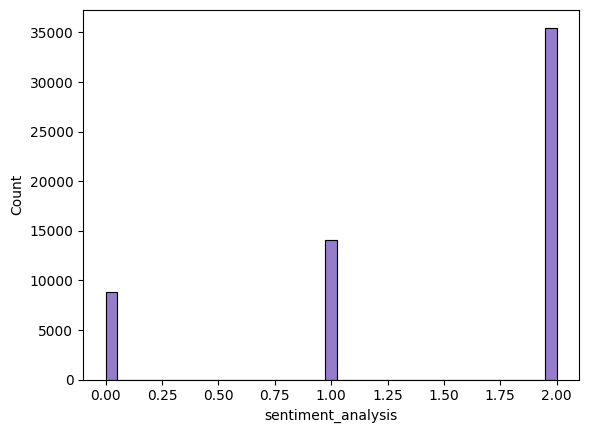

In [44]:
sns.histplot(df_to_parquet['sentiment_analysis'], color='#7251bc');

In [45]:
df_to_parquet.to_parquet('sentiment_analysis.parquet')

In [46]:
df_reseñas_final.head()

user_id  item_id  \
0  76561197970982479     1250   
1  76561197970982479    22200   
2  76561197970982479    43110   
3            js41637   251610   
4            js41637   227300   

                                        rev_complete  recommend     Año  \
0  simple great replayability opinion team work w...       True  2011.0   
1                           unique worth playthrough       True  2011.0   
2  great atmosphere gunplay bit chunky time end d...       True  2011.0   
3  know think see title barbie dreamhouse party i...       True  2014.0   
4  simple actually simple truck drive simulator q...       True  2013.0   

   sentiment_analysis  
0              1.8020  
1              1.2263  
2              1.8910  
3              1.8555  
4              1.9514

Se genera una nueva columna de análisis de sentimiento, en la cual las reseñas que quedaron vacías luego de ser lemmatizadas, serán asignadas como sentimiento 1 si el usuario recomendó el item, y como 0 si el usuario no lo recomendó

In [47]:
vacios = ['', ' ', [], [''], [' '], None]
df_reseñas_final['sentiment_analysis_2'] = df_reseñas_final['rev_complete'].progress_apply(lambda x: analyzer.polarity_scores(x)['compound'] if x not in vacios else (1 if df_reseñas_final.loc[df_reseñas_final['rev_complete'] == x, 'recommend'].any() == 1 else 0))

100%|██████████| 58431/58431 [00:52<00:00, 1108.35it/s]


In [48]:
df_reseñas_final.head()

user_id  item_id  \
0  76561197970982479     1250   
1  76561197970982479    22200   
2  76561197970982479    43110   
3            js41637   251610   
4            js41637   227300   

                                        rev_complete  recommend     Año  \
0  simple great replayability opinion team work w...       True  2011.0   
1                           unique worth playthrough       True  2011.0   
2  great atmosphere gunplay bit chunky time end d...       True  2011.0   
3  know think see title barbie dreamhouse party i...       True  2014.0   
4  simple actually simple truck drive simulator q...       True  2013.0   

   sentiment_analysis  sentiment_analysis_2  
0              1.8020                0.8020  
1              1.2263                0.2263  
2              1.8910                0.8910  
3              1.8555                0.8555  
4              1.9514                0.9514

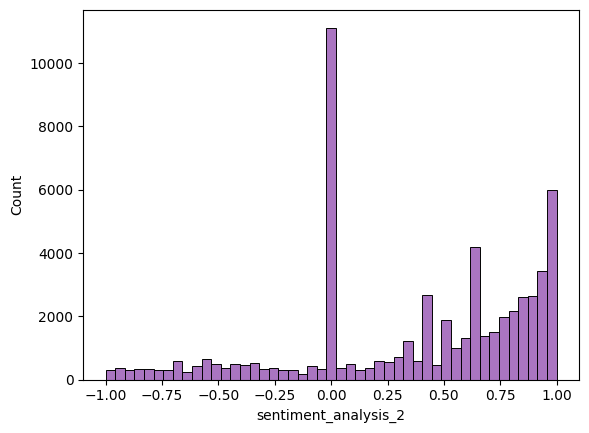

In [49]:
sns.histplot(df_reseñas_final['sentiment_analysis_2'], color='#8e47ad');

Se suma 1 al análisis de sentimiento para concordar con los valores requeridos.

In [50]:
df_reseñas_final['sentiment_analysis_2'] = df_reseñas_final['sentiment_analysis_2'] +1

In [51]:
df_reseñas_final.head()

user_id  item_id  \
0  76561197970982479     1250   
1  76561197970982479    22200   
2  76561197970982479    43110   
3            js41637   251610   
4            js41637   227300   

                                        rev_complete  recommend     Año  \
0  simple great replayability opinion team work w...       True  2011.0   
1                           unique worth playthrough       True  2011.0   
2  great atmosphere gunplay bit chunky time end d...       True  2011.0   
3  know think see title barbie dreamhouse party i...       True  2014.0   
4  simple actually simple truck drive simulator q...       True  2013.0   

   sentiment_analysis  sentiment_analysis_2  
0              1.8020                1.8020  
1              1.2263                1.2263  
2              1.8910                1.8910  
3              1.8555                1.8555  
4              1.9514                1.9514

Se genera un nuevo dataframe con esta nueva información

In [52]:
df_to_parquet_2 = df_reseñas_final[['user_id', 'item_id', 'sentiment_analysis_2', 'recommend', 'Año']]
df_to_parquet_2['sentiment_analysis_2'] = np.where(df_to_parquet_2['sentiment_analysis_2'] < 1 , 0, np.where(df_to_parquet_2['sentiment_analysis_2'] > 1, 2, 1 ))
df_to_parquet_2.head()

user_id  item_id  sentiment_analysis_2  recommend     Año
0  76561197970982479     1250                     2       True  2011.0
1  76561197970982479    22200                     2       True  2011.0
2  76561197970982479    43110                     2       True  2011.0
3            js41637   251610                     2       True  2014.0
4            js41637   227300                     2       True  2013.0

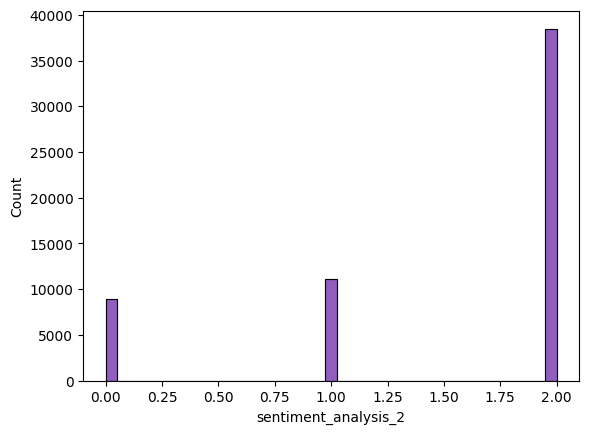

In [54]:
sns.histplot(df_to_parquet_2['sentiment_analysis_2'], color='#6d28aa');

Se hace un subplot para comparar eficazmente los gráficos generados

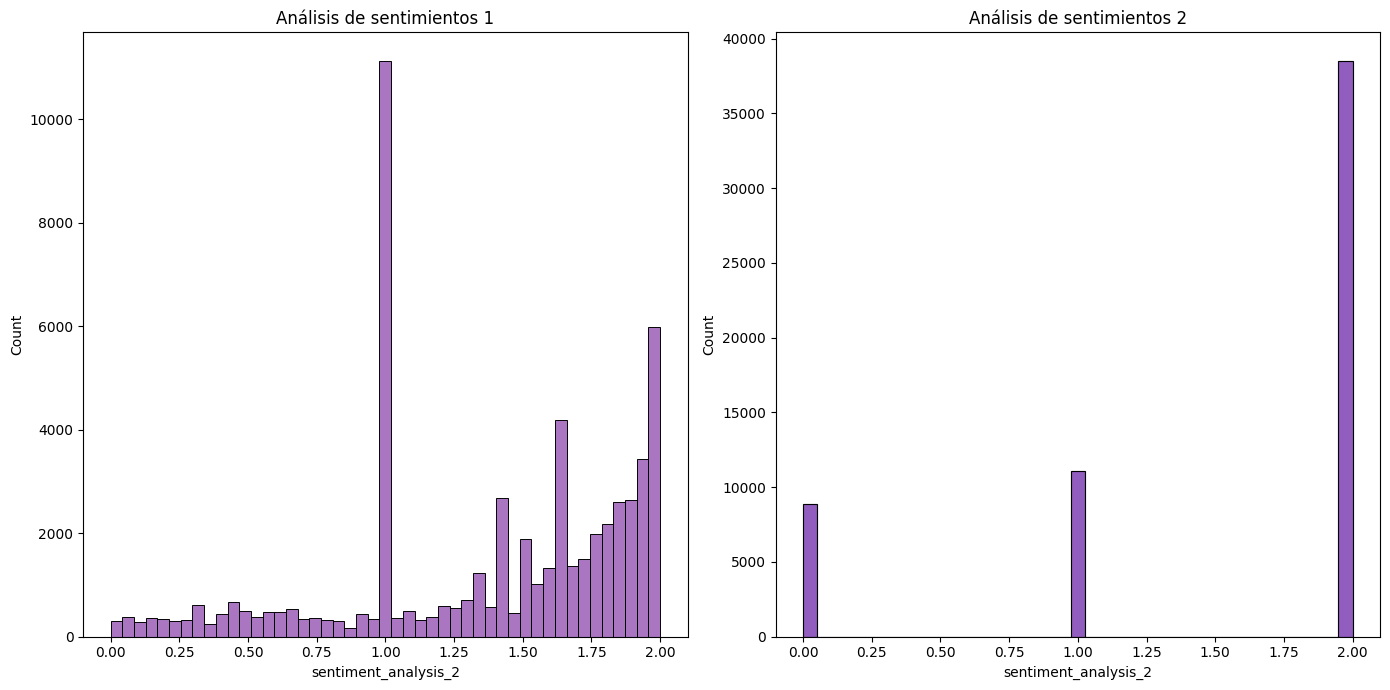

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Gráfico 1
sns.histplot(df_reseñas_final['sentiment_analysis_2'], color='#8e47ad', ax=axes[0])
axes[0].set_title('Análisis de sentimientos 1')

# Gráfico 2
sns.histplot(df_to_parquet_2['sentiment_analysis_2'], color='#6d28aa', ax=axes[1])
axes[1].set_title('Análisis de sentimientos 2')

plt.tight_layout()
plt.show()


In [57]:
df_to_parquet_2['sentiment_analysis_2'].value_counts()

sentiment_analysis_2
2    38495
1    11068
0     8868
Name: count, dtype: int64

In [58]:
df_to_parquet_2.head()

user_id  item_id  sentiment_analysis_2  recommend     Año
0  76561197970982479     1250                     2       True  2011.0
1  76561197970982479    22200                     2       True  2011.0
2  76561197970982479    43110                     2       True  2011.0
3            js41637   251610                     2       True  2014.0
4            js41637   227300                     2       True  2013.0

In [59]:
df_to_parquet_2.to_parquet('sentiment_analysis_2.parquet')

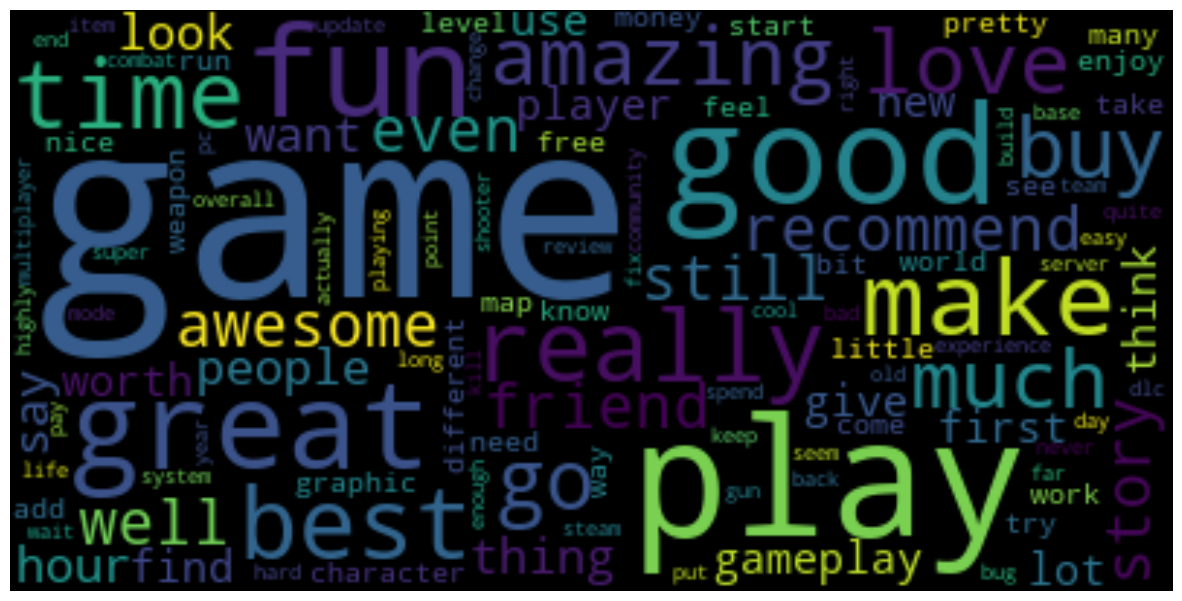

In [60]:
df_positivos = df_reseñas_final[df_reseñas_final['sentiment_analysis_2'] > 1]
text = " ".join(i for i in df_positivos['rev_complete'] if i is not None)
wordcloud = WordCloud(collocations=False).generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()